In [ ]:
import sys
import os
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# FUNCTIONS

#defining the function to remove punctuation
def clean_text(text):
    punctuationfree="".join([i.lower() for i in text if i not in string.punctuation])
    return punctuationfree

import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

def tokenize(text):
    tokens = text.split()
    # truncate if necessary
    if len(tokens) > 100:
        tokens = tokens[:100]
    return tokens

# creates word2vec model and returns list of word-vector embeddings
# sentences should be a list of lists of tokenized
def load_word_vectors(sentences):
    model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4)
    word_vectors = model.wv
    return word_vectors

def build_vocab(corpus):
    word_count = {}
    for sentence in corpus:
        for token in sentence:
            if token not in word_count:
                word_count[token] = 1
            else:
                word_count[token] += 1
    return word_count

def word2index(vocab):
    word_index = {w: i for i, w in enumerate(vocab)}
    idx_word = {i: w for i, w in enumerate(vocab)}
    return word_index, idx_word


def cosine_sim(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def data_cleaning(filename, filetype):
    
    data = pd.read_csv(filename, sep = "\t", names = ['s1', 's2', 'label', 'url'])
    # clean text
    data['s1_clean'] = data['s1'].apply(lambda x: clean_text(x))
    data['s2_clean'] = data['s2'].apply(lambda x: clean_text(x))

    # tokenize
    data['s1_tokens'] = data['s1_clean'].apply(lambda x: tokenize(x))
    data['s2_tokens'] = data['s2_clean'].apply(lambda x: tokenize(x))

    # create binary labels, ignoring 3,6 since these are inconclusive
    data = data[data.label != "(3,6)"]
    data['bin_label'] = data['label'].apply(lambda x: 0 if x in ['(0,6)', '(1,6)', '(2,6)'] else 1)

    # save to csv
    # data.to_pickle('twitter_corpus_clean.pkl')
    data.to_pickle(f'twitter_corpus_{filetype}_clean.pkl')

# reconstruct sentence from vectors
def sentence_reconstruct(vectors, word_vectors):
    sentence = []
    # remove padding
    rowsums = torch.sum(vectors,dim=1)
    indices = torch.nonzero(rowsums)
    end = indices[-1].item()
    vectors = vectors[:end+1]
    for i in range(len(vectors)):
        word = word_vectors.similar_by_vector(np.array(vectors[i]), topn=1)[0][0]
        sentence.append(word)
    
    return " ".join(w for w in sentence)    

In [ ]:
class SentencePairs(Dataset):
    
    def __init__(self, file, word_vectors, transform=None):
        self.data = pd.read_pickle(file)

        s1_tokens = self.data['s1_tokens']
        s2_tokens = self.data['s2_tokens']
        corpus = s1_tokens + s2_tokens

        self.transform = transform
        self.vocab = self.build_vocab(corpus)
        self.word_vectors = word_vectors
        self.word2idx, self.idx2word = self.word2index(self.vocab)
        self.idx2vec = self.index2vec(self.vocab)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get input sentences
        tokens1 = self.data['s1_tokens'].values[idx]
        tokens2 = self.data['s2_tokens'].values[idx]
        # convert words to index
        input1 = [self.word2idx[word] for word in tokens1]
        input2 = [self.word2idx[word] for word in tokens2]
        # get label
        label = self.data['bin_label'].values[idx]

        mat1 = [self.idx2vec[i] for i in input1]
        mat2 = [self.idx2vec[i] for i in input2]

        # build sample
        sentence1 = torch.tensor(np.array(mat1))
        sentence2 = torch.tensor(np.array(mat2))
        label = torch.tensor(np.array(label))
        
        # add padding, since max sequence length is 100, matrices should be 100x100
        pad1 = 100-sentence1.shape[0]
        pad2 = 100-sentence2.shape[0]
        sentence1 = F.pad(sentence1, (0,0,0,pad1))
        sentence2 = F.pad(sentence2, (0,0,0,pad2))

        return (sentence1, sentence2), label

    def build_vocab(self, corpus):
        word_count = {}
        for sentence in corpus:

            for token in sentence:
                # print(token)
                if token not in word_count:
                    word_count[token] = 1
                else:
                    word_count[token] += 1
        return word_count

    def word2index(self, vocab):
        word_index = {w: i for i, w in enumerate(vocab)}
        idx_word = {i: w for i, w in enumerate(vocab)}
        return word_index, idx_word
     
    def index2vec(self, vocab):
         word_index = {w: i for i, w in enumerate(vocab)}
         vec_index = {i: word_vectors[w] for i, w in enumerate(vocab)}
         return vec_index

In [ ]:
class Network(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size):
        super(Network, self).__init__()
        self.batch_size = batch_size
        self.layer_dim = 1
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, num_layers=self.layer_dim, batch_first=True)
        self.cos = nn.CosineSimilarity(dim=1)
        self.fc1 = nn.Linear(self.input_dim, self.input_dim)
        self.fc2 = nn.Linear(self.batch_size, 2)

    def forward(self, x1, x2):
 
        # LSTM
        h0 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)  
        c0 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        #print(x1.shape)
        rnn_out1, (hn1, cn1) = self.lstm(x1, (h0, c0))
        rnn_out2, (hn2, cn2) = self.lstm(x2, (h0, c0))
        # print(rnn_out1.shape)
        # linear
        dense1 = torch.relu(self.fc1(rnn_out1.squeeze(dim=2)))
        dense2 = torch.relu(self.fc1(rnn_out2.squeeze(dim=2)))
        #print(dense1.shape)
        # compute distance
        sim = self.cos(dense1, dense2)
        
        # Treat cosine similarity as probability of being paraphrase. But since this can output negative values, activate with ReLU to make them zero.
        # to address floating point errors, clamp outputs that are greater than 1
        out = torch.clamp(torch.relu(sim), min = 0, max = 1)

        return out
        #rnn_out1 = rnn_out1[:, -1, :].squeeze()
        #rnn_out2 = rnn_out2[:, -1, :].squeeze()
        
        # return out


In [ ]:
corpus_dir = "/content/drive/MyDrive/Corpus"
twitter_train = os.path.join(corpus_dir, "Twitter_URL_Corpus_train.txt")
twitter_test = os.path.join(corpus_dir, "Twitter_URL_Corpus_test.txt")

# read as tsv
data = pd.read_csv(twitter_train, sep = "\t", names = ['s1', 's2', 'label', 'url'])
test = pd.read_csv(twitter_test, sep = "\t", names = ['s1', 's2', 'label', 'url'])

In [ ]:
data_cleaning(twitter_train, "train")
data_cleaning(twitter_test, "test")

In [ ]:
# TODO: 
# Load csv
train = pd.read_pickle('twitter_corpus_train_clean.pkl')
test = pd.read_pickle('twitter_corpus_test_clean.pkl')
# Create vectorized data
# Create data loader

# compile list of all tokenized sentences
s1_tokens_test = test['s1_tokens'].values.tolist()
s2_tokens_test = test['s2_tokens'].values.tolist()
s1_tokens_train = train['s1_tokens'].values.tolist()
s2_tokens_train = train['s2_tokens'].values.tolist()
sentence_lists = s1_tokens_train + s2_tokens_train + s1_tokens_test + s2_tokens_test

# create word_vectors list
# vectorized_word = word_vectors[word], can also use list of words
word_vectors = load_word_vectors(sentence_lists)



In [ ]:
mydataset = SentencePairs(file = 'twitter_corpus_train_clean.pkl', word_vectors = word_vectors)
testdataset = SentencePairs(file = 'twitter_corpus_test_clean.pkl', word_vectors = word_vectors)

In [ ]:
# create DataLoader
BATCH_SIZE = 10

train_data, val_data = torch.utils.data.random_split(mydataset, 
                                [math.floor(len(mydataset)*0.8), 
                                math.floor(len(mydataset)*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 100, shuffle = True)

In [ ]:
# Train
device = 'cuda'

model = Network(input_dim = 100, hidden_dim = 1, batch_size = 10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.BCELoss()
log_interval = 100
train_counter = 0
train_step = []
train_loss = []
val_step = []
val_loss = []
val_acc = []
verbose=True
epochs = 20
total_batches = len(train_loader)
train_batch_size = 10
val_batch_size = 100
for epoch in range(epochs):
    for batch, (data, targets) in enumerate(train_loader):
        train_counter += 1

        # reshape so batch size is first dim
        input1 = data[0].to(device)
        input2 = data[1].to(device)
        model.train()
        
        optimizer.zero_grad()
        output = model(input1, input2)
        
        loss = loss_fn(output.squeeze().cpu(), targets.float().T) 
        loss.backward()
        optimizer.step()

        if (batch % log_interval == 0):
            train_step.append(train_counter)
            train_loss.append(loss.item())
            if (verbose):
                print(f'Epoch: {epoch+1}, Batch: {batch}/{total_batches}, Loss: {loss.item()}')
        
    # validate model at the end of each epoch
    val_step.append(train_counter)
    val_loss_tmp = []
    val_acc_tmp = []
    for batch, (val_data, val_targets) in enumerate(val_loader):
        model.eval()
    
        with torch.no_grad():
            input1 = val_data[0].to(device)
            input2 = val_data[1].to(device)
            val_output = model(input1, input2)
            loss = loss_fn(val_output.squeeze().cpu(), val_targets.float().T)
            val_loss_tmp.append(loss.item())
            correct = (torch.round(val_output.detach().cpu().T) == val_targets).type(torch.FloatTensor)
            val_acc_tmp.append(correct.mean())

    val_loss.append(np.mean(val_loss_tmp))
    val_acc.append(np.mean(val_acc_tmp))

KeyboardInterrupt: ignored

In [ ]:
# torch.save(model.state_dict(), "drive/MyDrive/Corpus/model_adam_20ep.pth")
model = Network(input_dim = 100, hidden_dim = 1, batch_size = 10)
model.to(device)
model.load_state_dict(torch.load("drive/MyDrive/Corpus/model_adam_20ep.pth"))

<All keys matched successfully>

Text(0, 0.5, '% Correct')

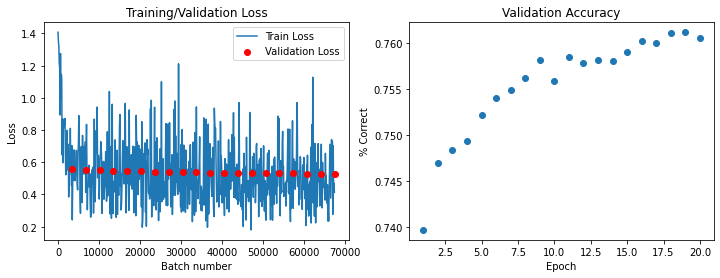

In [ ]:
# output loss and accuracy
%matplotlib inline
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.scatter(val_step, val_loss, c="Red", zorder = 1);
plt.plot(train_step, train_loss, zorder = -1);
plt.title("Training/Validation Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Validation Loss']);
plt.subplot(122)
plt.scatter(np.arange(start=1,stop=len(val_acc)+1), val_acc);
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("% Correct")


In [ ]:
# Testing accuracy
test_loader = torch.utils.data.DataLoader(testdataset, batch_size = 1, shuffle = True)
model.eval()
test_acc = []
results = {'TP':[], 'TN':[], 'FP':[], 'FN':[]}
TP = 0
TN = 0
FP = 0
FN = 0
threshold = 0.5
with torch.no_grad():
    for batch, (data, label) in enumerate(test_loader):
        input1 = data[0]
        input2 = data[1]
        # print(input1.shape)
        s1, s2 = sentence_reconstruct(input1.squeeze(), word_vectors),sentence_reconstruct(input2.squeeze(), word_vectors)
        output = model(input1.to(device), input2.to(device))
        pred = output.detach().cpu().item()
        if (pred < threshold):
            pred = 0
        else:
            pred = 1

        # print(pred, label.item())
        if label.item() == 1:
            if pred == 1:
                TP +=1
                results['TP'].append((s1,s2, output.detach().cpu().item()))
            else:
                FN +=1
                results['FN'].append((s1,s2, output.detach().cpu().item()))
        else:
            if pred == 1:
                FP +=1
                results['FP'].append((s1,s2, output.detach().cpu().item()))
            else:
                TN +=1
                results['TN'].append((s1,s2, output.detach().cpu().item()))
        correct = (pred == label).type(torch.FloatTensor)


        test_acc.append(correct.mean())

In [ ]:
TP+FN, FP+TN

(1821, 7513)

In [ ]:
rand_tp =results['TP'][random.randint(0,len(results['TP'])] results['TN'][random.randint(0,len(results['TN'])] ,results['FP'][random.randint(0,len(results['FP'])],results['FN'][random.randint(0,len(results['FN'])]

SyntaxError: ignored

In [ ]:
rand_tp = results['TP'][random.randint(0,len(results['TP']))]
rand_tn = results['TN'][random.randint(0,len(results['TN']))]
rand_fp = results['FP'][random.randint(0,len(results['FP']))]
rand_fn = results['FN'][random.randint(0,len(results['FN']))]
newline = '\n'
print(f'True Positive: {rand_tp}{newline}True Negative: {rand_tn}{newline}False Positive: {rand_fp}{newline}False Negative: {rand_fn}')


True Positive: ('protesters planning to blockade inauguration checkpoints party outside pence home', 'protesters vow to blockade dc party at pence home', 0.6887482404708862)
True Negative: ('trump attorney sheri dillon trump will sever presidency from his business organization', 'full details of how pres elect trump and his lawyers have decided to separate his business activities', 0.19050614535808563)
False Positive: ('after a year in jail a woman accused of attempting a coathanger abortion has pleaded guilty to one felony', 'napw in todays the new york times her plea cannot be seen as any kind of validation for the use of criminal', 0.5070196986198425)
False Negative: ('the iconic boeing 747 jumbo jet is headed for us retirement this year', 'queen jumbo 747 heads for us retirement this year', 0.4280935227870941)


In [ ]:
precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1=(2*precision*recall)/(precision+recall)
accuracy = (TP+TN)/(TP+TN+FP+FN)

In [ ]:
precision, recall, f1, accuracy

(0.4440400363967243,
 0.26798462383305877,
 0.33424657534246577,
 0.7917291622026998)

In [ ]:
(input1, input2), label = test_loader.dataset[random.randint(0,len(test_loader.dataset))]

In [ ]:
pred = model(input1.view(1,100,100).to(device), input2.view(1,100,100).to(device))
pred, label, sentence_reconstruct(input1, word_vectors),sentence_reconstruct(input2, word_vectors)

(tensor([0.2619], device='cuda:0', grad_fn=<ClampBackward1>),
 tensor(0),
 'trump shrugs off dems inauguration boycott i hope they give me their tickets',
 'ill take a couple of those tickets realdonaldtrump the wife amp i would be honored to attend your inauguration')

In [ ]:
input1.shape

torch.Size([100, 100])

In [ ]:
sentence_reconstruct(input1, word_vectors),sentence_reconstruct(input2, word_vectors)

('the exmi6 agent who compiled a dossier on donald trump left his home to avoid possible retribution neighbors say',
 'christopher steele exspy who compiled trump dossier goes to ground')